# Analyzing 10 years of Social Media activity

Produced by [Vivek K R](https://www.linkedin.com/in/imvivek98/)

In this notebook, I have used my brother's Facebook and Instagram data (with his consent of course), procured over the course of the last 10 years (2010-2020) to try and perform exploratory data analysis using Python. Through this project, among other things, I intend to find out how his social media usage has varied over different phases of his life, his preference among the two social media platforms, the impact of Covid-19 and the subsequent quarantine period on his social media usage, and the variation of his sleep cycle over the years.

### Exporting Data from Facebook

If compiling data from users is an art, then facebook would be the Picasso of it (Nobody, nobody does it better). Exporting data from facebook is actually pretty simple. You go to `Settings` - `Download your information`, and it lets you download a copy of your information at any time. You can specify the types of information, date ranges and the format in which you want to recieve it. I exported all of the data in JSON format.

### Exporting Data from Instagram

Instagram isn't too far behind when it comes to acquiring data from its users. Inorder to export data from instagram you should go to `Settings` - `Security` - `Download data` and request a download link of all your stuff. It gives an entire history of your life at instagram in JSON format. 

![](https://hist1.latestly.com/wp-content/uploads/2020/09/18-FB-INSTA-380x214.jpg)

The sheer amount of data you get from these social media sites is a reminder of how much they know about you. Just for the sake of his privacy, I will only be dealing with the numbers (i.e., the number of interactions and other activities) on a daywise basis rather than using any actual content from his data (he has facebook and instagram doing that work for him anyway).

#### How to run this notebook?

This notebook was created for partial fulfilment of the requirements of the course [Data Analysis with Python: Zero to Pandas](https://jovian.ml/learn/data-analysis-with-python-zero-to-pandas) offered by [Jovian.ml](jovian.ml) in partnership with [freecodecamp](https://www.freecodecamp.org/). The recommended way to run this notebook is to click the "Run" button at the top of this page, and select "Run on Binder". This will run the notebook on [mybinder.org](https://mybinder.org/), a free online service for running Jupyter notebooks. Alternatively, you could install Python and download this notebook on your computer to run it locally. The [conda](https://www.anaconda.com/products/individual#Downloads) distribution of python is recommended for this.

## Python libraries used

* [`re`](https://docs.python.org/3/library/re.html) - Provides regular expression matching operations similar to those found in Perl
* [`datetime`](https://docs.python.org/3/library/datetime.html) - Helps in manipulating dates and times
* [`pytz`](https://pypi.org/project/pytz/) - Performs accurate timezone calculations
* [`numpy`](https://numpy.org/doc/stable/reference/index.html) - Brings the computational power of languages like C and Fortran to Python
* [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) - Easy to use data analysis tool built on top of python
* [`matplotlib`](https://matplotlib.org/3.3.1/contents.html) - Comprehensive library for creating visualizations in python
* [`seaborn`](https://seaborn.pydata.org/tutorial.html) - Data visualization based on `matplotlib` to make the plots prettier
* [`jovian`](https://www.jovian.ml/?utm_source) - Platform for sharing and collaborating on data science projects

First we import these libraries. Run the next line without the `#` if you haven't already installed these libararies in your environment.

In [1]:
#!pip install datetime pytz numpy pandas matplotlib seaborn jovian --upgrade --quiet
from datetime import datetime
import re, pytz
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import jovian

## Loading Facebook and Instagram data into a Pandas Dataframe

I divided up the acquired data into 3 categories:
1. **Interactions**: These include likes, reactions, liking/following a page, adding new friends/followers and the good ol' pokes.
2. **Posts and Comments**: These include all the times he made effort to actually post or comment something.
3. **Views and searches**: These include the content he has seen and the searches he has made.

**NOTE:** *Skip to the next section if you just wanna get started with the analysis*

All of the facebook data that was downloaded existed in a format similar to this. 
```
{
  "reactions": [
    {
      "timestamp": 1600062269,
      "data": [
        {
          "reaction": {
            "reaction": "LIKE",
            "actor": "Vaisakh KR"
          }
        }
      ],
      "title": "Vaisakh KR likes The witty doctor's photo."
    },
...
```
A function `updateDF_timestamp` was written to append these timestamp events into a dataframe column corresponding to the category into which they fell. It finds the unique occurences of timestamps of the format `"timestamp": [0-9]+` using regular expressions, converts them to datetimes (in IST) and appends them into a new row while also specifying their category. It then returns this new dataframe.

In [2]:
def updateDF_timestamp(path,dataframe,datetime_index,category_index):
    '''
    Input parameters are:
    1. `path`- path of the file in string format
    2. `dataframe`- Dataframe onto which the data is to be updated
    3. `datetime_index`- Index of the column where the datetime is to be updated
    4. `category_index`- Index of the column where the category is to be updated
    Note: Do not consider the index column while calculating indices
    Returns updated dataframe
    '''
    # Finding all unique occurences of timestamps while ignoring special characters which can't be parsed
    tstamps = [int(x) for x in set(re.findall('"timestamp": ([0-9]+)',open(path,errors='ignore').read()))]
    for tstamp in tstamps:
        if tstamp == 0: continue
        # Converting timestamp to datetimes in IST and appending a new row
        dt = pd.Timestamp(tstamp,unit='s',tz='Asia/Kolkata')
        col = [0 for _ in range(dataframe.shape[1])]
        col[datetime_index] = dt; col[category_index] = 1
        dataframe.loc[len(dataframe)] = col
    return dataframe

All of the instagram data that was downloaded existed in this format
```
["2019-12-28T03:54:39+00:00", "imvivek98"], ["2019-12-28T02:26:41+00:00", "offensiventmalayalammemes"], ...
```
The datetimes are present in the ISO 8601 Datetime format and hence another function would be required to append these events into a dataframe. A function `updateDF_iso8601` was written, which is very similar to `updateDF_timestamp` except that it deals with ISO 8601 datetimes rather than timestamps.

In [3]:
def updateDF_iso8601(path,dataframe,datetime_index,category_index):
    '''
    Input parameters are:
    1. `path`- path of the file in string format
    2. `dataframe`- Dataframe onto which the data is to be updated
    3. `datetime_index`- Index of the column where the datetime is to be updated
    4. `category_index`- Index of the column where the category is to be updated
    Note: Do not consider the index column while calculating indices
    Returns updated dataframe
    '''
    # Finding all unique occurences of timestamps while ignoring special characters which can't be parsed
    iso_8601 = re.findall('"([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]T[0-9][0-9]:[0-9][0-9]:[0-9][0-9]\+00:00)"',
                         open(path,errors='ignore').read())
    
    for iso in iso_8601:
        # Converting ISO 8601 datetime strings to python datetimes in IST and appending a new row
        dtUTC = datetime.strptime(iso,'%Y-%m-%dT%H:%M:%S+00:00')
        dt = pd.to_datetime(dtUTC.replace(tzinfo=pytz.UTC).astimezone(pytz.timezone('Asia/Kolkata')))
        col = [0 for _ in range(dataframe.shape[1])]
        col[datetime_index] = dt; col[category_index] = 1
        dataframe.loc[len(dataframe)] = col
    return dataframe

Now that that's done, let's create an empty dataframe and also a list of the path of all the files which needs to be added to the empty dataframe. This is done carefully so that column indices of the dataframe matches the list indices.

In [4]:
social_df = pd.DataFrame(columns=['datetime','fb_interactions','fb_posts','fb_views_searches',
                                  'insta_interactions','insta_posts','insta_views_searches'])

fb_list = [['likes_and_reactions/pages.json','likes_and_reactions/posts_and_comments.json',
            'friends/received_friend_requests.json','friends/rejected_friend_requests.json',
            'friends/removed_friends.json','friends/sent_friend_requests.json','other_activity/pokes.json',
            "ads_and_businesses/advertisers_you've_interacted_with.json",'other_activity/polls_you_voted_on.json'],           
           ['comments/comments.json','posts/your_posts_1.json'],           
           ['about_you/viewed.json','about_you/visited.json','search_history/your_search_history.json']]

insta_list = [['connections.json','likes.json','saved.json','stories_activities.json'],
              ['comments.json','media.json'],
              ['searches.json','seen_content.json']]

Now we feed them into the function and see some information about the resultant dataframe.

In [5]:
%%time
for ind,category in enumerate(fb_list):
    for path in category:
        path = './facebook-imvaisakh7/' + path
        social_df = updateDF_timestamp(path=path,dataframe=social_df,datetime_index=0,category_index=ind+1)
for ind,category in enumerate(insta_list):
    for path in category:
        path = './vaisakh_kr_20200921/' + path
        social_df = updateDF_iso8601(path=path,dataframe=social_df,datetime_index=0,category_index=len(fb_list)+ind+1)
        
social_df.info()        

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74385 entries, 0 to 74384
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   datetime              74385 non-null  object
 1   fb_interactions       74385 non-null  object
 2   fb_posts              74385 non-null  object
 3   fb_views_searches     74385 non-null  object
 4   insta_interactions    74385 non-null  object
 5   insta_posts           74385 non-null  object
 6   insta_views_searches  74385 non-null  object
dtypes: object(7)
memory usage: 4.5+ MB
Wall time: 17min 42s


That was quite a bit of data and hence took around 15 mins to perform the functions. We can see that there are 74385 entries and a total of 7 columns. After we set the `datetime` column as the index, we are finally ready to view our dataframe!

In [6]:
social_df.set_index(social_df.datetime,inplace=True)
social_df.drop(columns=['datetime'],inplace=True)
social_df

,fb_interactions,fb_posts,fb_views_searches,insta_interactions,insta_posts,insta_views_searches
datetime,,,,,,
2018-09-30 13:20:55+05:30,1,0,0,0,0,0
2016-06-12 22:35:32+05:30,1,0,0,0,0,0
2014-03-10 14:38:37+05:30,1,0,0,0,0,0
2015-05-14 11:43:50+05:30,1,0,0,0,0,0
2014-03-09 12:35:47+05:30,1,0,0,0,0,0
...,...,...,...,...,...,...
2020-07-24 14:24:25+05:30,0,0,0,0,0,1
2020-07-23 23:20:03+05:30,0,0,0,0,0,1
2020-07-23 23:20:02+05:30,0,0,0,0,0,1


## Exploratory data analysis starts from here

For our purposes here, we will be adding a few extra columns to the dataframe by making use of the additive property of the pandas series as well as the properties of the `DateTimeIndex` column. Also, we will consider data obtained from both the social media platforms only till the 31st of August 2020 to make our analysis consistent.

In [7]:
social_df['fb_total'] = social_df.fb_interactions + social_df.fb_posts + social_df.fb_views_searches
social_df['insta_total'] = social_df.insta_interactions + social_df.insta_posts + social_df.insta_views_searches
social_df['grand_total'] = social_df.fb_total + social_df.insta_total
social_df.insert(0,'date',social_df.index.date)
social_df.insert(1,'year',social_df.index.year)
social_df.insert(2,'month',social_df.index.month)
social_df.insert(3,'day',social_df.index.day)
social_df.insert(4,'day_of_week',social_df.index.weekday)
social_df.insert(5,'hour',social_df.index.hour)
social_df = social_df[social_df.date < pd.to_datetime('2020-09-01')]

In [8]:
social_df

,date,year,month,day,day_of_week,hour,fb_interactions,fb_posts,fb_views_searches,insta_interactions,insta_posts,insta_views_searches,fb_total,insta_total,grand_total
datetime,,,,,,,,,,,,,,,
2018-09-30 13:20:55+05:30,2018-09-30,2018,9,30,6,13,1,0,0,0,0,0,1,0,1
2016-06-12 22:35:32+05:30,2016-06-12,2016,6,12,6,22,1,0,0,0,0,0,1,0,1
2014-03-10 14:38:37+05:30,2014-03-10,2014,3,10,0,14,1,0,0,0,0,0,1,0,1
2015-05-14 11:43:50+05:30,2015-05-14,2015,5,14,3,11,1,0,0,0,0,0,1,0,1
2014-03-09 12:35:47+05:30,2014-03-09,2014,3,9,6,12,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-24 14:24:25+05:30,2020-07-24,2020,7,24,4,14,0,0,0,0,0,1,0,1,1
2020-07-23 23:20:03+05:30,2020-07-23,2020,7,23,3,23,0,0,0,0,0,1,0,1,1
2020-07-23 23:20:02+05:30,2020-07-23,2020,7,23,3,23,0,0,0,0,0,1,0,1,1


Before asking questions about the dataset let's write this dataframe to a csv file to make sure we don't lose our data. 

In [9]:
social_df.to_csv('./social_activity.csv')

Whether you're running this Jupyter notebook on an online service like Binder or on your local machine, it's important to save your work from time to time, so that you can access it later, or share it online. You can upload this notebook to your Jovian.ml account using the jovian Python library.

In [10]:
project='analyzing-social-media-activity'
jovian.commit(project=project,files=['./social_activity.csv'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "imvivek-98/analyzing-social-media-activity" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Uploading additional files...
[jovian] Committed successfully! https://jovian.ml/imvivek-98/analyzing-social-media-activity


'https://jovian.ml/imvivek-98/analyzing-social-media-activity'

Remove the `#` from the next cell to load the dataframe from the csv file attached with this notebook.

In [11]:
#social_df = pd.read_csv('./social_activity.csv',index_col='datetime')
#social_df

### 1. How has his social media usage varied over the years?

In [12]:
columns = ['fb_interactions','fb_posts','fb_views_searches','insta_interactions','insta_posts',
           'insta_views_searches','fb_total','insta_total','grand_total']
yearwise_df = social_df.groupby('year')[columns].sum()
yearwise_df

,fb_interactions,fb_posts,fb_views_searches,insta_interactions,insta_posts,insta_views_searches,fb_total,insta_total,grand_total
year,,,,,,,,,
2010,165,40,0,0,0,0,205,0,205
2011,1388,1602,8,0,0,0,2998,0,2998
2012,3112,1246,18,0,0,0,4376,0,4376
2013,7683,8706,145,0,0,0,16534,0,16534
2014,1914,781,33,0,0,0,2728,0,2728
2015,2444,789,12,0,0,0,3245,0,3245
2016,9875,737,567,208,10,0,11179,218,11397
2017,7649,712,696,377,23,66,9057,466,9523
2018,5546,413,836,569,12,68,6795,649,7444


While his instagram usage started from 2016, it seems that he has been using facebook since 2010. Let's plot some graphs to get a better picture of his social media usage over different phases of his life.

In [13]:
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = (12,6.5)
mpl.rcParams['font.size'] = 12.5
mpl.rcParams['lines.linewidth'] = 3.5
mpl.rcParams['lines.linestyle'] = '--'

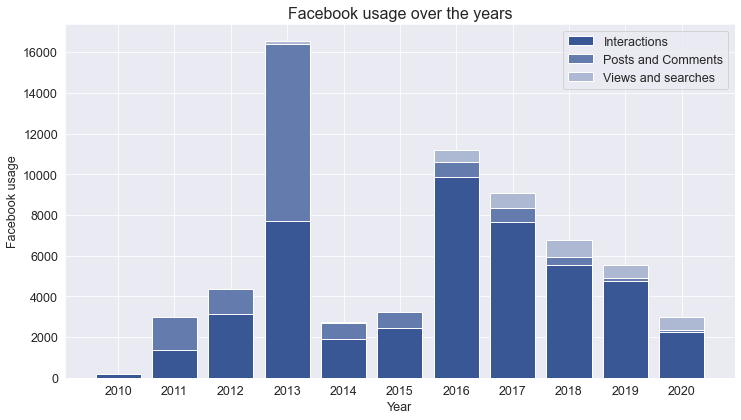

In [14]:
plt.bar(yearwise_df.index,yearwise_df.fb_interactions,color='#3A5795')
plt.bar(yearwise_df.index,yearwise_df.fb_posts,bottom=yearwise_df.fb_interactions,color='#637BAD')
plt.bar(yearwise_df.index,yearwise_df.fb_views_searches,bottom=yearwise_df.fb_interactions+yearwise_df.fb_posts,color='#ADB9D3')

plt.xlabel('Year')
plt.ylabel('Facebook usage')
plt.xticks(yearwise_df.index)
plt.title('Facebook usage over the years',fontsize=16)
plt.legend(['Interactions','Posts and Comments','Views and searches']);

The general trend, as expected, seems to be one in which his facebook usage goes up and then comes down (the decreasing popularity of facebook among the youth is no secret). But oops! There seems to be a disparity to this trend in the years 2014 and 2015. Does it have to do with errors that crept in while loading our dataframe? Or maybe we forgot to consider some data collected in those two years? Of course not.

If you know anything about being a student in India, you would straightaway realize that those were the years he was preparing for his entrance examinations. Another feature that you would notice immediately is the huge decrease in the amount of posts and comments after it hit a peak in 2013, which was when he was very active in various groups in facebook.

Now let us take a look at his Instagram usage.

In [15]:
since_2016 = yearwise_df[yearwise_df.index >= 2016]

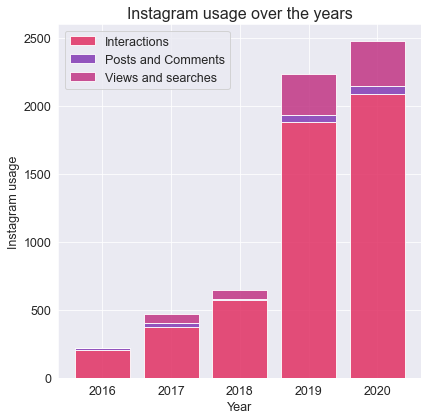

In [16]:
plt.figure(figsize=(6.5,6.5))
plt.bar(since_2016.index,since_2016.insta_interactions,color='#E13063',alpha=0.85)
plt.bar(since_2016.index,since_2016.insta_posts,bottom=since_2016.insta_interactions,color='#833AB4',alpha=0.85)
plt.bar(since_2016.index,since_2016.insta_views_searches,
        bottom=since_2016.insta_interactions+since_2016.insta_posts,color='#C13584',alpha=0.85)


plt.xlabel('Year')
plt.ylabel('Instagram usage')
plt.xticks(since_2016.index)
plt.title('Instagram usage over the years',fontsize=16)
plt.legend(['Interactions','Posts and Comments','Views and searches']);

We can see that he started using instagram after joining college in 2016, right after the 'great dip'. Since then, we can see a considerable growth in the amount of his instagram usage (note that the 2020 plot is only till the month of August). We also infer that he doesn't post or comment much on instagram, but still spends quite a lot of time there doomscrolling and liking content. Now we can combine the two in a single graph.

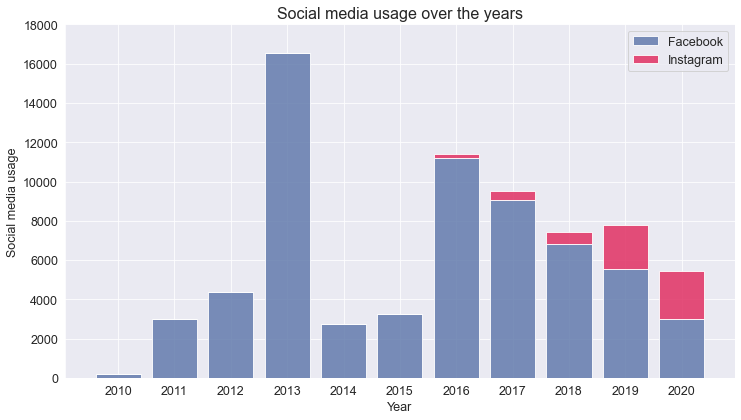

In [17]:
plt.bar(yearwise_df.index,yearwise_df.fb_total,color='#637BAD',alpha=0.85)
plt.bar(yearwise_df.index,yearwise_df.insta_total,color='#E13063',bottom=yearwise_df.fb_total,alpha=0.85)

plt.xlabel('Year')
plt.ylabel('Social media usage')
plt.xticks(yearwise_df.index)
plt.title('Social media usage over the years',fontsize=16)
plt.legend(['Facebook','Instagram'])
plt.xticks(yearwise_df.index)
plt.ylim([0,18000]);

Which brings me to my next question...

### 2. Facebook vs. Instagram?

Okay I can see the smirk on your face. And yeah I agree, when it comes to the whole of my brother's life, instagram doesn't even stand a chance and facebook seems to be the undisputed winner. This can be confirmed by just taking the sum of the `fb_total` and `insta_total` columns.

In [18]:
social_df[['fb_total','insta_total']].sum()

fb_total       65638.0
insta_total     6042.0
dtype: float64

But there seems to be some interesting developments recently and the divide seems to be not that significant. Let's take a look his monthwise distribution of social media usage in this year.

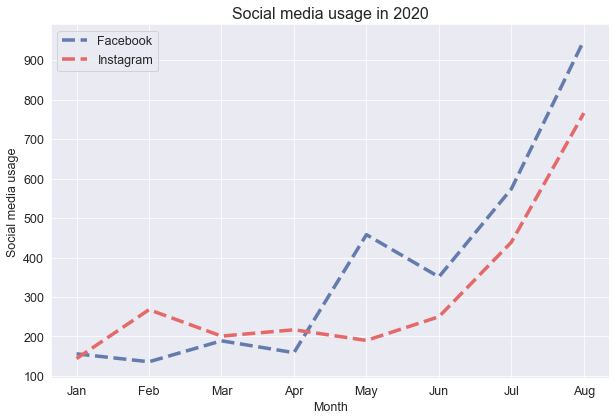

In [19]:
plt.figure(figsize=(10,6.5))
year2020 = social_df[social_df.year == 2020].groupby('month')[columns].sum()
plt.plot(year2020.fb_total,color='#637BAD')
plt.plot(year2020.insta_total,color='#e56969')

plt.xlabel('Month')
plt.ylabel('Social media usage')
month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks=year2020.index,labels=month_list[:8])
plt.title('Social media usage in 2020',fontsize=16)
plt.legend(['Facebook','Instagram']);

Instagram has not yet managed to pose a real challenge to his inclination towards facebook, but it's certainly on the right path.

### 3. When does my brother sleep?

Inorder to answer this question, we are only going to consider data from May 2016, as that was the time in which he got his first smartphone. I think we would be able to get a rough idea about his sleep cycle by plotting his hourwise social media usage for every month across 4 years on a heatmap. We just have a very basic assumption that whenever he's not on social media for a considerably large amount of time, he's sleeping (which sadly, lies very close to reality for most of us).


In [20]:
mwcolumn = list()
for y in range(2016,2021):
    for m in range(12):
        mwcolumn.append('{}-{}'.format(month_list[m],y))
hour_list = ['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am',
             '12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm']
sleep_df = pd.DataFrame(index=hour_list,columns=mwcolumn).fillna(0)
for y in range(2016,2021):
    for m in range(12):
        value_df = social_df[(social_df.year == y) & (social_df.month == m+1)].groupby('hour')['grand_total'].sum()
        for h in range(24):
            if h not in value_df.index: continue
            sleep_df.loc[hour_list[h],'{}-{}'.format(month_list[m],y)] = value_df[h]
sleep_df = sleep_df.iloc[:,8:-4]

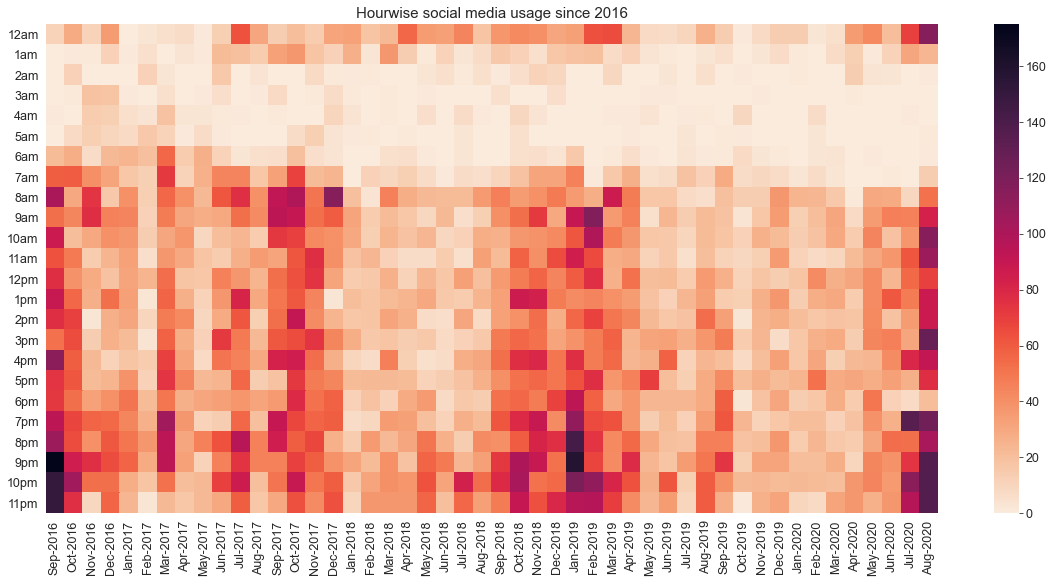

In [21]:
plt.figure(figsize=(20,9))
sns.heatmap(sleep_df,cmap='rocket_r')
plt.title('Hourwise social media usage since 2016');

Generally, we can see that my brother is not exactly a night owl like most people of his age. On an average, he sleeps around 1 or 2 at night. There seems to be some segregated activity early in the morning on some months which would probably be the times when he tried to go to the gym or started playing badmintion with his fellow hostelites. Anyway, let's look at the data yearwise before coming to a proper conclusion.

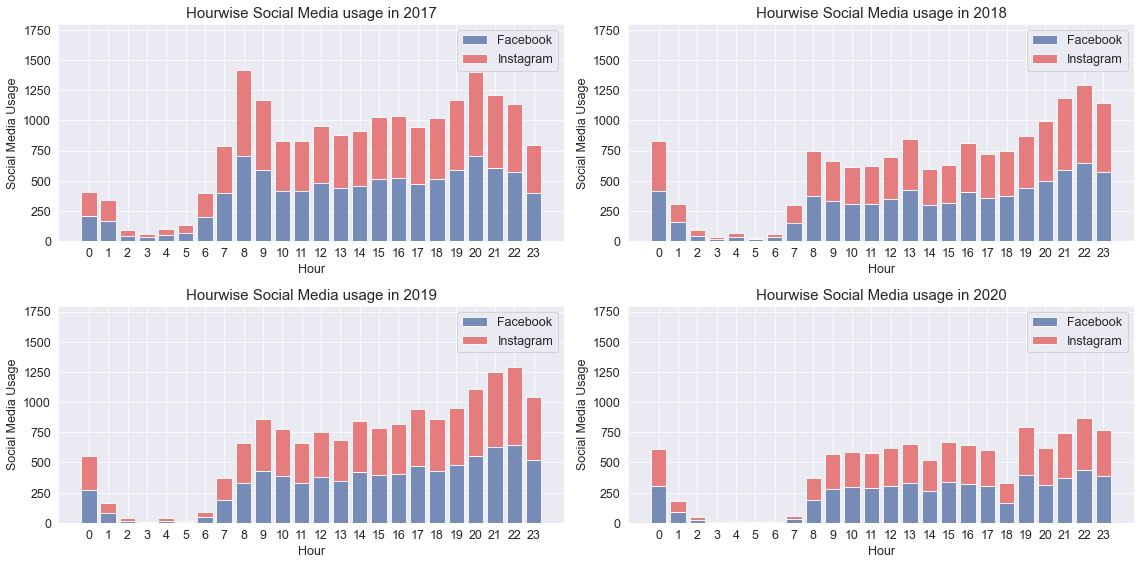

In [26]:
fig, axes = plt.subplots(2,2,figsize=(16,8))

for y in range(2017,2021):
    sleep_data = social_df[social_df.year==y].groupby('hour')[['fb_total','insta_total']].count()
    if y == 2017: ax = 0,0
    if y == 2018: ax = 0,1
    if y == 2019: ax = 1,0
    if y == 2020: ax = 1,1
    axes[ax].bar(sleep_data.index,sleep_data.fb_total,color='#637BAD',alpha=0.85)
    axes[ax].bar(sleep_data.index,sleep_data.insta_total,color='#e56969',bottom=sleep_data.fb_total,alpha=0.85)
    axes[ax].set_xlabel('Hour')
    axes[ax].set_ylabel('Social Media Usage')
    axes[ax].set_title('Hourwise Social Media usage in {}'.format(y))
    axes[ax].legend(['Facebook','Instagram'])
    axes[ax].set_ylim([0,1800])
    axes[ax].set_xticks(ticks=sleep_data.index)
    
plt.tight_layout(pad=1);

We can see that he goes to sleep consistently by around 1-2am at night but the time he wakes up has varied from around 6am in 2017 to 8am in 2020. This variation in 2020 would be largely because of the quarantine situation wherein he doesn't have to wake up and rush to college so as to not lose his attendance for the first lecture. This sets us up nicely for our next question.

### 4. How has quarantine been treating him?

In the previous section, we got a sense of how quarantine was messing up and altering his sleep pattern. Note that for keeping track of just his recent habits and to keep our analysis conistent, we will split our data into two equal dataframes `before_covid` and `after_covid` which will contain data from August 2019 to February 2020 and March 2020 to August 2020 respectively (he has been home since March 2020).

As always let's plot some graphs to visualize the difference.

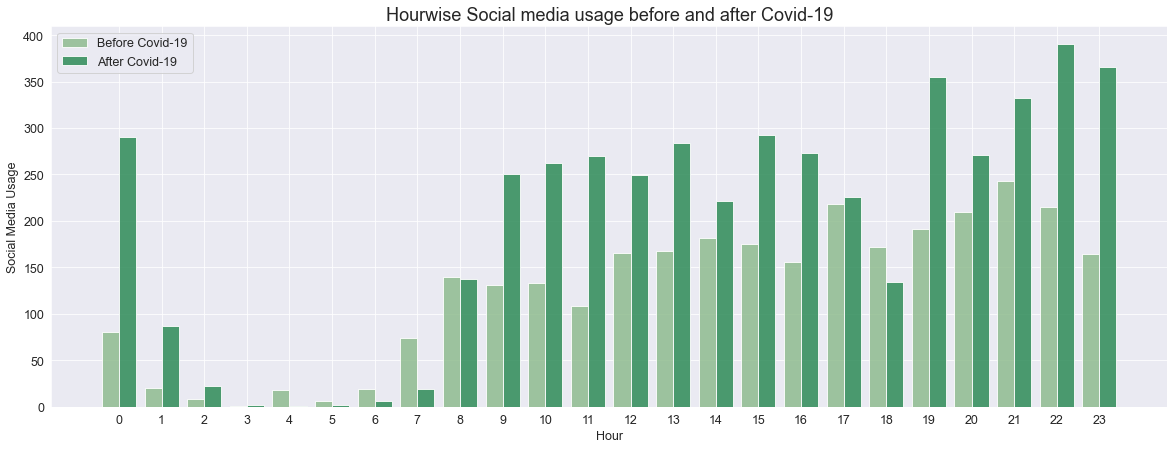

In [27]:
before_covid = social_df[(social_df.date >= pd.to_datetime('2019-08-01'))&(social_df.date < pd.to_datetime('2020-03-01'))]
after_covid = social_df[social_df.date >= pd.to_datetime('2020-03-01')]

hour_before_covid = before_covid.groupby('hour')[['grand_total']].sum()
hour_after_covid = after_covid.groupby('hour')[['grand_total']].sum()

plt.figure(figsize=(20,7))
indices = range(24)
width = np.min(np.diff(indices))/2 - 0.1
plt.bar(indices-width,hour_before_covid.grand_total,width,color='darkseagreen',alpha=0.85)
plt.bar(indices,hour_after_covid.grand_total,width,color='seagreen',alpha=0.85)
plt.xlabel('Hour')
plt.ylabel('Social Media Usage')
plt.title('Hourwise Social media usage before and after Covid-19',fontsize=18)
plt.legend(['Before Covid-19','After Covid-19'])
plt.xticks(indices - width / 2, range(24));

We can see that since March 2020, he has indeed been sleeping and waking up a bit later than usual. You can also see his increasing social media usage during this period, which should be not a surprising thing at all for most of us. Just to make sure, we can calculate the percentage increase in his social media activity during this period.

In [28]:
usage_before_covid = before_covid.groupby('date')['grand_total'].sum().mean()
usage_after_covid = after_covid.groupby('date')['grand_total'].sum().mean()

percent_increase = (usage_after_covid - usage_before_covid)*100/usage_before_covid
print('Perentage increase in usage since March 2020 is {0:.2f}'.format(percent_increase))

Perentage increase in usage since March 2020 is 81.46


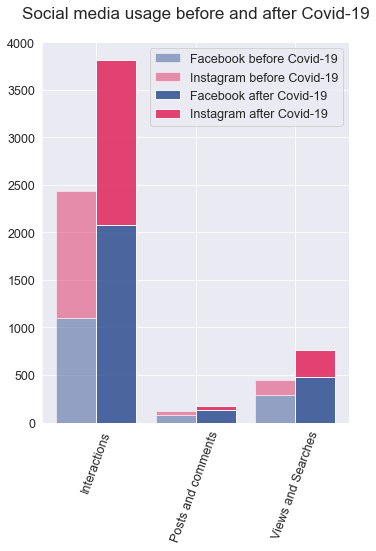

In [31]:
categories = ['fb_interactions','fb_posts','fb_views_searches','insta_interactions','insta_posts','insta_views_searches']
plt.figure(figsize=(5.5,7))
indices = range(3)
width = np.min(np.diff(indices))/2 - 0.1
plt.bar(indices-width,before_covid[categories].sum()[:3],width,color='#3A5795',alpha=0.50)
plt.bar(indices-width,before_covid[categories].sum()[3:],width,bottom=before_covid[categories].sum()[:3],
        color='#E13063',alpha=0.50)
plt.bar(indices,after_covid[categories].sum()[:3],width,color='#3A5795',alpha=0.90)
plt.bar(indices,after_covid[categories].sum()[3:],width,bottom=after_covid[categories].sum()[:3],color='#E13063',alpha=0.90)
plt.xticks(indices - width / 2, ['Interactions','Posts and comments','Views and Searches'],rotation = 70);
plt.legend(['Facebook before Covid-19','Instagram before Covid-19','Facebook after Covid-19','Instagram after Covid-19'])
plt.title('Social media usage before and after Covid-19\n',fontsize=17);

Except in the `posts_and_comments` category which doesn't seem to be varying much, his interactions, views and searches seem to be going up. His social media activity has gone up by a whooping 81.46% since quarantine, which is again not that surprising. Now onto our last question.

### 4. Does he spend more time on social media on weekends?

Let's compute the sum of all his activity on different days of the week.

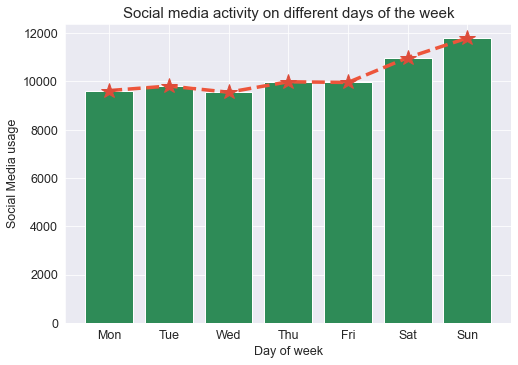

In [32]:
plt.figure(figsize=(8,5.5))
weekend_series = social_df.groupby('day_of_week')['grand_total'].sum()
plt.plot(weekend_series,color='#ed553b',marker='*',linestyle='--',ms=16,mfc='#dd4c3a',mec='#dd4c3a')
plt.bar(weekend_series.index,weekend_series,color='seagreen')
plt.xlabel('Day of week')
plt.ylabel('Social Media usage')
plt.title('Social media activity on different days of the week')
plt.xticks(range(7),labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

There seems to be a slight increase in his social media activity during weekends (here weekend corresponds to the `day_of_week` 5 and 6) as compared to that during weekdays. Let's now write a function which calculates this percentage increase.

In [33]:
def PercentageIncrease_weekends(series):
    '''
    This function takes in a series indexed by the day of week (Monday is 1 and Sunday is 0)
    and returns the percentage increase of the corresponding value in weekends
    '''
    mean_weekdays = series[series.index < 5].mean()
    mean_weekends = series[series.index > 4].mean()
    return (mean_weekends-mean_weekdays)*100/mean_weekdays

print('Perentage increase of social media usage during weekends is {0:.2f}'.format(PercentageIncrease_weekends(weekend_series)))

Perentage increase of social media usage during weekends is 16.41


We see a 16.41% increase. Now let's split up the data yearwise to see if his college life or the advent of smartphones have affected this trend.

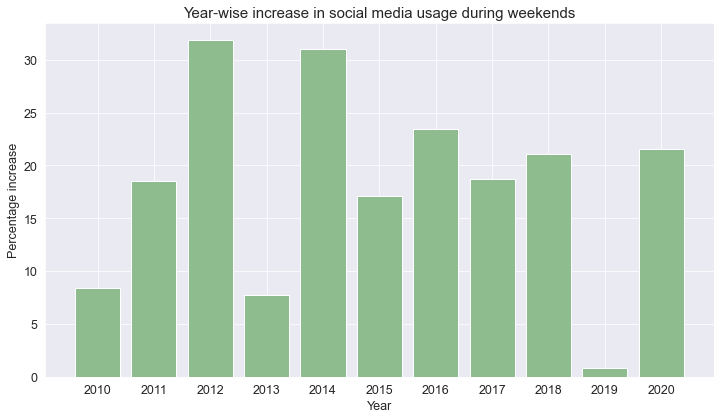

In [34]:
per_incr = list()
years = range(2010,2021)
for y in years:
    temp = social_df[social_df.year == y].groupby('day_of_week')['grand_total'].sum()
    per_incr.append(PercentageIncrease_weekends(temp))
plt.bar(years,per_incr,color='darkseagreen')
plt.xlabel('Year')
plt.ylabel('Percentage increase')
plt.title('Year-wise increase in social media usage during weekends')
plt.xticks(years);

There is atleast a 15% increase in social media usage during weekends for all years except 2010, 2013 and 2019. The most significant difference occurs in the years 2012 and 2014, where the percentage increase goes as high as 30%. Although the divide is pretty clear from the graph, it can't be said with certainty that this trend is affected by his college life or the advent of smartphones.

## Inferences and Conclusions

Through this notebook, I have tried to explore and analyze my brother's social media usage across the last 10 years. After exporting data from both his facebook and instagram accounts, I created a dataframe containing a record of his social media activity. This was divided into 3 categories - `Interactions`, `Posts and Comments` and `Views and Searches`. After the dataframe was prepared, questions were asked and answered about the dataset which led to the following inferences:
* Since joining facebook in 2010, the amount of time spent on the social media site has increased exponentially untill about 2013, which was the year which had registered the highest amount of facebook activities. 
* The next two years marked the times when he was the least active on facebook. This was largely because of the fact that he was preparing for his entrance examinations to get into a good medical college.
* Once he got into one in 2016, his facebook usage came back on track, although never reaching the high that was set in 2013. This was also the time when he created and started using his instagram account, albeit for a very minimum amount of time.
* We have also seen that since about 2016 he hasn't been posting as much as he did in earlier years, but rather spends his time liking/reacting and doomscrolling past his newsfeed. This is especially true in the case of Instagram.
* Two new trends start to emerge in the following years - Facebook usage starts to decrease and Instagram usage seems to be finding its way up the graph. Although it hasn't managed to pose a real challenge to his inclination towards facebook, we can say that it's certainly on the right path.
* Within 2-3 years, there is a good chance that instagram might overtake facebook in terms of the amount of time he spends on each of these sites.
* We also looked at the hourwise distribution of his social media activity throughout the years and found out that he usually sleeps by around 1-2am and wakes up by around 7am. This trend is shifted by about an hour during 2020 where he sleeps and wakes up a bit later than usual.
* This was verified to be due to the pandemic crisis and the subsequent quarantine that followed. It was also found that his social media usage had further gone up by about 81.46% during a 12 month period before and after the Covid-19 crisis.
* Lastly, his increased social media activity by about 16.41% during weekends (Saturdays and Sundays) was recognised, with the largest increase coming in the years 2012 and 2014 and the lowest coming in 2019. A yearwise divide was carried out to check for trends but none was found out.

Finally, let's save and commit our work

In [ ]:
jovian.commit(project=project,files=['./social_activity.csv'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


## References

1. Downloading digital personal information - https://www.popsci.com/download-digital-personal-information/
2. Regular Expressions by Charles Severance - [Part 1](https://www.youtube.com/watch?v=ovZsvN67Glc), [Part 2](https://www.youtube.com/watch?v=fiar4QZZ7Xo) and [Part 3](https://www.youtube.com/watch?v=GiQdXo2Bvgc)
3. Convert Unix epoch into datetimes for a particular timezone - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html
4. Convert strings to datetime objects - https://www.programiz.com/python-programming/datetime/strptime
5. pytz user guide for converting ISO 8601 datetimes - http://pytz.sourceforge.net/
6. Pandas user guide: https://pandas.pydata.org/docs/user_guide/index.html
7. Matplotlib user guide: https://matplotlib.org/3.3.1/users/index.html
8. Seaborn user guide & tutorial: https://seaborn.pydata.org/tutorial.html